In [22]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth
from sklearn.preprocessing import StandardScaler as Scaler

from scipy.stats import mannwhitneyu as mnu

import statsmodels.api as sm

from sklearn.metrics.pairwise import cosine_similarity as cosine
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from scipy.stats import kendalltau as kendall

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

## Definitions ##

In [2]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def mk_repmat_kernel(input_ls, plot_kernel=False):
    '''
    Args:
        input_ls:    list with the number of samples per condition, i.e., 
                     the list size is the number of categories
        plot_kernel: if True, the created kernel will be plotted
    Returns:
        kernel: (N,N) theoretical ground-truth representatational matrix,
                where N is the total number of samples
    '''

    kernel = np.zeros([sum(input_ls),sum(input_ls)])
    counter_ind = 0
    for i in input_ls:
        inds = np.arange(counter_ind, counter_ind+i)
        counter_ind += i
        kernel[np.ix_(inds,inds)] = 1
        
    if plot_kernel:
        plt.figure(figsize=(2,2))
        plt.imshow(kernel, cmap='coolwarm')
        plt.axis('off')

    return kernel


def mk_repmat_data(input_data, sim_method='cosine', print_info=False):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
        print_info: if True, the progression will be printed
    Returns:
        repmat: (N,N) representatational matrix, where N is the total number of samples
    '''

    if sim_method=='cosine':
        repmat = cosine(input_data.T)
    elif sim_method=='spearman':
        CorRows = []
        for stim_i in range(input_data.shape[1]):
            CorCols = []
            for stim_j in range(input_data.shape[1]):
                CorCols.append(spearman(input_data[:,stim_i], input_data[:,stim_j])[0])

                if print_info:
                    print('stim_i: ' + str(((stim_i+1)/input_data.shape[1])*100) +
                          ' | ' + 'stim_j: ' + str(((stim_j+1)/input_data.shape[1])*100))

            CorRows.append(CorCols)
        repmat = np.array(CorRows)
    
    return repmat

def mk_total_repmat_data(input_data, sim_method='cosine'):
    '''
    Args:
        input_data: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        sim_method: method for creating representatational matrix
                    cosine, for cosine similarity
                    spearman, for spearman correlation 
    Returns:
        total_repmat: (N,N,T) representatational matrix, where N is the total number of samples and
                      T is the number of time-points
    '''

    total_repmat = []
    for iTime in range(input_data.shape[2]):
        tmp_retmat = mk_repmat_data(input_data=input_data[:,:,iTime], sim_method=sim_method, print_info=False)
        total_repmat.append(tmp_retmat)
    return np.transpose(np.array(total_repmat), (1,2,0))


def plot_repmat(input_repmat, plot_sz=3, show_clb=False, titles=[], colormap='coolwarm', cbar_label='Cosine Similarity (au)', fig_title=''):
    '''
    Args:
        input_repmat: (M,N,N) representatational matrices, where M is the number of conditions and
                      N is the total number of samples
        plot_sz:      size of the generated plot
        show_clb:     if True, colorbar will be shown
        titles:       list of titles of each representatational matrix
        colormap:     colormap for the generated plot
        cbar_label:   colorbar label
    Returns:
        none
    '''

    if not titles: titles=['']*len(input_repmat)
    if show_clb==True:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat)+1, figsize=(3*plot_sz,plot_sz),  dpi=500)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=len(input_repmat), figsize=(3*plot_sz,plot_sz),  dpi=500)

    for ax,repmat,tle in zip(axs.flatten(), input_repmat, titles):
        ax.imshow(repmat, cmap=colormap)
        ax.set_title(tle, fontsize=5)
        ax.axis('off')
    if show_clb:
        clb = mbar.ColorbarBase(ax=axs[-1], cmap=colormap, orientation="vertical", ticks=[0,1])
        clb.set_label(cbar_label, fontsize=plot_sz*3)
        clb.outline.set_visible(False)
    plt.suptitle(fig_title, fontsize=plot_sz*10)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def compute_similarity(data_mat, kernel_mat, sim_method='kendall'):
    '''
    Args:
        data_mat:   (N,N) representatational matrix created from data,
                    where N is the number of conditions
        kernel_mat: (N,N) theoretical ground-truth representatational matrix,
                    where N is the number of conditions
        sim_method: method to calculate similarity
    Returns:
        similarity: similarity value between data_mat and kernel_mat
    '''
    if sim_method!='kendall':
        data_mat = data_mat.reshape((data_mat.shape[0]**2,1))
        kernel_mat = kernel_mat.reshape((kernel_mat.shape[0]**2,1))

    if sim_method=='kendall':
        similarity = kendall(data_mat, kernel_mat)[0]
    elif sim_method=='spearman':
        similarity = spearman(data_mat, kernel_mat)[0]
    elif sim_method=='pearson':
        similarity = pearson(data_mat, kernel_mat)[0]

    return similarity


def compute_rsa(data_input, conds_ls=[], sp_kernel=[], sim_method='kendall', print_info=False):
    '''
    Args:
        data_input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        conds_ls:   list with the number of samples per condition, i.e., the list size is the number
                    of categories, and each item is the number of stimuli per that category
        sp_kernel:  (N,N) representatational matrix, i.e., specific kernel,
                    where N is the number of stimuli
        sim_method: method to calculate similarity
        print_info: if True, the progression will be printed
    Returns:
        rsa: (N,) vector of similarity values, where N is the number of timepoints
    '''
    
    if not sp_kernel: kernel = mk_repmat_kernel(conds_ls)
    elif not conds_ls: kernel = sp_kernel

    rsa = []
    for i_time in range(data_input.shape[2]):
        temp_mat = []
        temp_mat = mk_repmat_data(data_input[:,:,i_time])
        rsa.append(compute_similarity(temp_mat, kernel, sim_method))

        if print_info:
            print('% ' + str(((i_time+1)/data_input.shape[2])*100))
            
    return np.array(rsa)


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)

    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count



In [3]:
def comp_residuals(regressors, input_data, reg_to_exc, base_time_idx, normalized=True):
    '''
    Args: 
    '''

    tmp_regressor = np.delete(regressors, reg_to_exc, axis=1)

    residuals = np.zeros_like(input_data) * np.nan
    norm_residuals = np.copy(residuals)

    for ineuron in tqdm(range(input_data.shape[0])):
        for itime in range(input_data.shape[2]):
            tmp_mdl = LinearRegression(fit_intercept=False).fit(tmp_regressor, input_data[ineuron,:,itime])
            residuals[ineuron,:,itime] = input_data[ineuron,:,itime] - tmp_mdl.predict(tmp_regressor)
        
        base_ave = np.nanmean(np.nanmean(residuals[ineuron,:,base_time_idx], axis=0))
        base_std = np.nanstd(np.nanmean(residuals[ineuron,:,base_time_idx], axis=0))
        norm_residuals[ineuron,:,:] = np.array((residuals[ineuron] - base_ave)) / base_std

    if normalized:
        return norm_residuals
    else:
        return residuals

# Load Data

In [4]:
# load data
FigDir = '../Results/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# model
alpha = 25

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = [255/255, 187/255, 112/255, 80/255], [129/255, 104/255, 157/255, 80/255]
color_class1 = [145, 100, 80, 80];
color_class2 = [43, 57, 144, 80]

# parameters
cycle_num = 200
SmoothWin = 20
step = 1
time_base = 80

abs_level = 2
if abs_level == 1:
    myCond = 'Animacy'
    stim_num = 50
    indc1 = np.arange(0,175,1)
    indc2 = np.arange(175,335,1)
elif abs_level == 2:
    myCond = 'FaceBody'
    stim_num = 20
    indc1 = np.arange(0,35,1)
    indc2 = np.arange(35,75,1)
ind_all = np.concatenate((indc1, indc2), axis=0)
cat_inds = [indc1,indc2]

# sub-sampling
if 1:
    idx_rand = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)
else:
    idx_rand = rand_idx_gen(cycle_num, [ind_all], 2*stim_num, replacement=False)

resp_itc, time_stamps = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
stim_info = pd.read_excel('../utils/stim_info.xlsx')
# stim_info.head(2)

vis_feat = pd.read_csv('../utils/vis_feature_py.csv')
# vis_feat.head()

ind_stim = np.concatenate((np.arange(2,180,6), [186,188,193,196,197], np.arange(200,500)), axis=0)

col_names = ['anim', 'face', 'body', 'huma', 'monk']
# col_names = ['anim', 'face', 'body']
df = pd.DataFrame()
for col_name in col_names:
    df[col_name] = pd.get_dummies(stim_info[col_name].iloc[ind_stim], drop_first=True, dtype=int)

df = df.reset_index(drop=True)

df['circ'] = vis_feat['circ']
df['elong'] = vis_feat['elong']
df['spike'] = vis_feat['spike']
df['contrast'] = vis_feat['contrast']

if 0:
   df['pc1'] = vis_feat['pc1']
   df['pc2'] = vis_feat['pc2']

if 0:
   df['pc1'] = Scaler().fit_transform(np.array(vis_feat['pc1']).reshape(-1,1))
   df['pc2'] = Scaler().fit_transform(np.array(vis_feat['pc2']).reshape(-1,1))

if 1:
    MatFeatures_dir = '../utils/vis_feature_mat_NoBG.mat'
    mat_features = loadmat(MatFeatures_dir)
    # df['contrast'] = mat_features['Contrast'][0]
    df['luminance'] = mat_features['Luminance'][0]
    df['objArea'] = mat_features['objArea'][0]

conds = df.columns.to_list()

regressor = np.array(df)
print(regressor.shape)
df.head(2)


(335, 11)


,anim,face,body,huma,monk,circ,elong,spike,contrast,luminance,objArea
0,1,1,0,1,0,0.819194,0.261044,0.016938,0.855492,0.331287,0.974963
1,1,1,0,1,0,0.771879,0.267206,0.026045,0.879470,0.323011,0.979519


# Compute Residuals

In [ ]:
idx_time = 220
idx_neuron = 0

tmp_resp = resp_itc[idx_neuron,:,idx_time]

y_resp = tmp_resp - np.nanmean(tmp_resp)
sst = y_resp @ y_resp.T

tmp_mdl = sm.GLM(val_itc[tmp_rand,itime], sm.add_constant(regressor[tmp_rand])).fit()

NameError: name 'tmp_mdl' is not defined

In [426]:
if abs_level == 1:
    col_to_ex = 0
elif abs_level == 2:
    col_to_ex = [1,2]

base_time_idx = (time_stamps<0)

norm_res_itc = comp_residuals(regressor, resp_itc, col_to_ex, base_time_idx, normalized=True)
norm_res_pfc = comp_residuals(regressor, resp_pfc, col_to_ex, base_time_idx, normalized=True)

if 0:
    isample = 1
    fig_sz = np.array((4,2)) * 1
    plt.figure(figsize=fig_sz)
    plt.plot(time_stamps, smooth(np.nanmean(norm_res_itc[isample], axis=0), 2), label='norm')
    plt.legend()

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [25]:
if 0:
    
    if abs_level == 1:
        col_to_ex = 0
    elif abs_level == 2:
        col_to_ex = [1,2]
    tmp_regressor = np.delete(regressor, col_to_ex, axis=1)

    base_time_idx = (time_stamps<0)

    residual_itc = np.zeros_like(resp_itc) * np.nan
    norm_res_itc = np.zeros_like(resp_itc) * np.nan

    for ineuron in tqdm(range(resp_itc.shape[0])):
        for itime in range(resp_itc.shape[2]):
            tmp_mdl = LinearRegression(fit_intercept=True).fit(tmp_regressor, resp_itc[ineuron,:,itime])
            residual_itc[ineuron,:,itime] = resp_itc[ineuron,:,itime] - tmp_mdl.predict(tmp_regressor)
        
        base_ave = np.nanmean(np.nanmean(residual_itc[ineuron,:,base_time_idx], axis=0))
        base_std = np.nanstd(np.nanmean(residual_itc[ineuron,:,base_time_idx], axis=0))
        norm_res_itc[ineuron,:,:] = np.array((residual_itc[ineuron] - base_ave)) / base_std


    residual_pfc = np.zeros_like(resp_pfc) * np.nan
    norm_res_pfc = np.zeros_like(resp_pfc) * np.nan

    for ineuron in tqdm(range(resp_pfc.shape[0])):
        for itime in range(resp_pfc.shape[2]):
            tmp_mdl = LinearRegression(fit_intercept=True).fit(tmp_regressor, resp_pfc[ineuron,:,itime])
            residual_pfc[ineuron,:,itime] = resp_pfc[ineuron,:,itime] - tmp_mdl.predict(tmp_regressor)
        
        base_ave = np.nanmean(np.nanmean(residual_pfc[ineuron,:,base_time_idx], axis=0))
        base_std = np.nanstd(np.nanmean(residual_pfc[ineuron,:,base_time_idx], axis=0))
        norm_res_pfc[ineuron,:,:] = np.array((residual_pfc[ineuron] - base_ave)) / base_std


    if 0:
        isample = 48
        fig_sz = np.array((4,2)) * 1
        plt.plot(time_stamps, smooth(np.nanmean(norm_res_itc[isample,:,:], axis=0), 2), label='norm')
        plt.plot(time_stamps, smooth(np.nanmean(residual_itc[isample,:,:], axis=0), 2), label='raw')
        plt.legend()


([<matplotlib.axis.YTick at 0x2296b8d6850>,
 [Text(0, -8, '−8'), Text(0, 0, '0'), Text(0, 8, '8')])

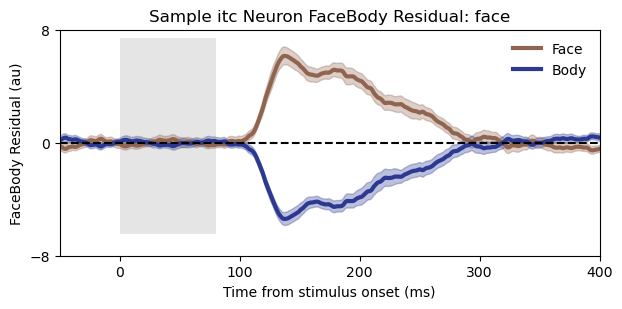

In [794]:
isample_itc = 117
pref_cond = 'face'
area = 'itc'
fig_sz = np.array((4,2)) * 1.5

smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = 8; plot_ylim = [-plot_ylim,plot_ylim]

labels = ['Face', 'Body']

m_plot([norm_res_itc[isample_itc,indc1,:], norm_res_itc[isample_itc,indc2,:]], [color_class1,color_class2], error_method='sem', 
       smooth_win=smooth_win, labels=labels, plot_title=f'Sample {area} Neuron {myCond} Residual: {pref_cond}', timepoints=time_stamps, figure_size=fig_sz)

plt.axhline(0, ls='--', color='k', lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

# plt.savefig(f'{FigDir}residual_sampleNeuron_{myCond}_{pref_cond}_{area}_num{isample_itc}.svg')

([<matplotlib.axis.YTick at 0x2296c5bb4d0>,
 [Text(0, -2.5, '−2.5'), Text(0, 0.0, '0.0'), Text(0, 2.5, '2.5')])

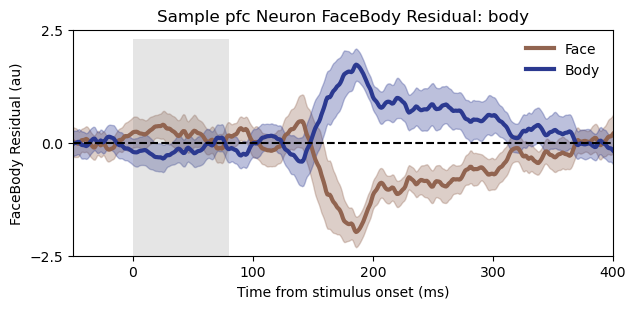

In [807]:
isample_pfc = 103
pref_cond = 'body'
area = 'pfc'
fig_sz = np.array((4,2)) * 1.5

smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = 2.5; plot_ylim = [-plot_ylim,plot_ylim]

labels = ['Face', 'Body']

m_plot([norm_res_pfc[isample_pfc,indc1,:], norm_res_pfc[isample_pfc,indc2,:]], [color_class1,color_class2], error_method='sem', 
       smooth_win=smooth_win, labels=labels, plot_title=f'Sample {area} Neuron {myCond} Residual: {pref_cond}', timepoints=time_stamps, figure_size=fig_sz)

plt.axhline(0, ls='--', color='k', lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

# plt.savefig(f'{FigDir}residual_sampleNeuron_{myCond}_{pref_cond}_{area}_num{isample_pfc}.svg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.YTick at 0x2288ba6f650>,
 [Text(0, -0.2, '−0.2'), Text(0, 0.4, '0.4')])

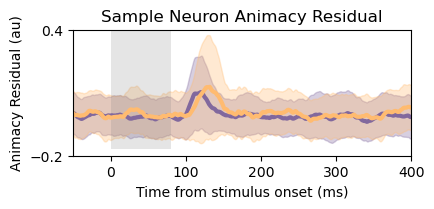

In [26]:
isample_itc = 1
isample_pfc = 10
smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = [-.2,.4]
fig_sz = np.array((4,2)) * 1

m_plot([norm_res_pfc[isample_pfc], norm_res_itc[isample_itc]], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, plot_title=f'Sample Neuron {myCond} Residual', timepoints=time_stamps, figure_size=fig_sz)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}residual_sampleNeuron_{myCond}.svg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.YTick at 0x14017abe3d0>,
 [Text(0, -0.2, '−0.2'), Text(0, 0.4, '0.4')])

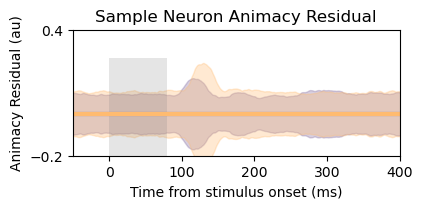

In [308]:
isample_itc = 1
isample_pfc = 10
smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = [-.2,.4]
fig_sz = np.array((4,2)) * 1

m_plot([norm_res_pfc[isample_pfc], norm_res_itc[isample_itc]], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, plot_title=f'Sample Neuron {myCond} Residual', timepoints=time_stamps, figure_size=fig_sz)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}residual_sampleNeuron_{myCond}.svg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(14.222222222222223, 0.5, 'Animacy Residual (au)')

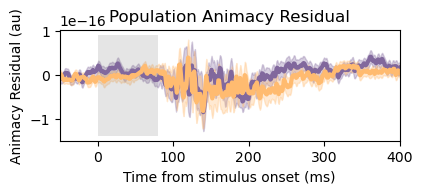

In [310]:
isample_itc = 1
isample_pfc = 10
smooth_win = 1
plot_xlim = [-50,400]
plot_ylim = [-.01,.05]
fig_sz = np.array((4,2)) * 1

pop_res_itc = np.nanmean(norm_res_itc, axis=1)
pop_res_pfc = np.nanmean(norm_res_pfc, axis=1)

m_plot([pop_res_pfc, pop_res_itc], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, plot_title=f'Population {myCond} Residual', timepoints=time_stamps, figure_size=fig_sz)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel(f'{myCond} Residual (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])

# plt.savefig(f'{FigDir}residual_population_{myCond}.svg')

# RSA

In [311]:
rsa_itc = np.zeros((cycle_num,time_stamps.shape[0])) * np.nan
rsa_pfc = np.copy(rsa_itc)

for icycle,tmp_idx in tqdm(enumerate(idx_rand)):
    rsa_itc[icycle] = compute_rsa(norm_res_itc[:,tmp_idx,:], conds_ls=[stim_num,stim_num])
    rsa_pfc[icycle] = compute_rsa(norm_res_pfc[:,tmp_idx,:], conds_ls=[stim_num,stim_num])
    

0it [00:00, ?it/s]

MannwhitneyuResult(statistic=12988.0, pvalue=0.13339805053992435)


Text(0.5, 1.0, 'RSA Solution Time for Animacy')

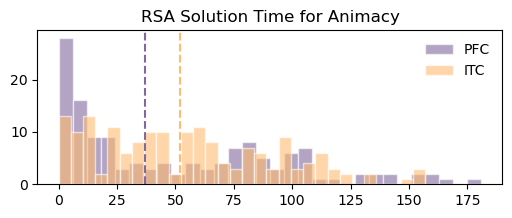

In [312]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peaksss_itc, onsetsss_itc, solsss_itc, _ = FindResp(rsa_itc, time_stamps, base_time_idx)
_, peaksss_pfc, onsetsss_pfc, solsss_pfc, _ = FindResp(rsa_pfc, time_stamps, base_time_idx)

figure_size=(6,2)

plt.figure(figsize=figure_size)

plot_num = 3
if plot_num==1:
    plt.hist(peaksss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(peaksss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    print(mnu(peaksss_itc, peaksss_pfc, nan_policy='omit'))
    plot_ylim = [0,8]
    plot_title = 'Peak Time'
    
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    print(mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit'))
    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    # print(wilcoxon(solsss_itc, solsss_pfc, nan_policy='omit'))
    print(mnu(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(f'RSA {plot_title} for {myCond}')

([<matplotlib.axis.YTick at 0x140428ffd50>,
 [Text(0, -0.02, '−0.02'), Text(0, 0.0, '0.00'), Text(0, 0.08, '0.08')])

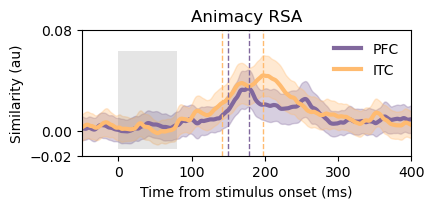

In [314]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [-.02,.08]
fig_sz = np.array((4,2)) * 1

iter_correct_itc = rsa_itc[(~np.isnan(onsetsss_itc))]
iter_correct_pfc = rsa_pfc[(~np.isnan(onsetsss_pfc))]

m_plot([iter_correct_pfc,iter_correct_itc], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'{myCond} RSA', timepoints=time_stamps, figure_size=fig_sz)

plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)

plt.axvline(np.nanmedian(peaksss_pfc), ls='--', color=color_pfc_n[:3], alpha=1, lw=fig_sz[1]*.5)
plt.axvline(np.nanmedian(peaksss_itc), ls='--', color=color_itc_n[:3], alpha=1, lw=fig_sz[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Similarity (au)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 0, plot_ylim[1]])

# plt.savefig(f'{FigDir}residual_rsa_{myCond}_both.svg')

Onset ITC = 141.0 -+ 35.61912125962625
Onset PFC = 149.0 -+ 43.61090315710459
Onset Mann-Whitney p = 0.8382283354060551
-----
Peak ITC = 198.0 -+ 29.154536347185786
Peak PFC = 179.0 -+ 42.868797057912474
Peak Mann-Whitney p = 0.10051829917112157
-----
Solution ITC = 52.0 -+ 38.369594002864254
Solution PFC = 37.0 -+ 46.66543643215888
Solution Mann-Whitney p = 0.13339805053992435


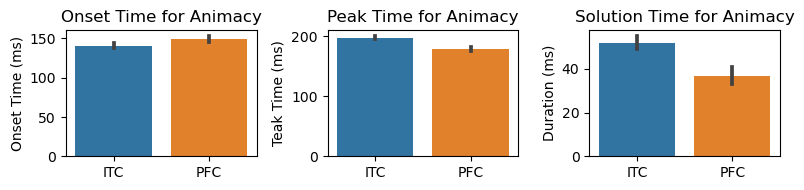

In [315]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
# error_method = ('ci', 95)
# error_method = 'sd'
error_method = 'se'
bar_xticks = ["ITC", "PFC"]

plt_onset = sns.barplot(ax=ax[0], data=[onsetsss_itc, onsetsss_pfc], estimator='median', errorbar=error_method)
# ax[0].set_ylim([90,150])
# ax[0].set_yticks([90,120,150])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {myCond}')
plt_onset.set(xticklabels=bar_xticks)

plt_peak = sns.barplot(ax=ax[1], data=[peaksss_itc, peaksss_pfc], estimator='median', errorbar=error_method)
# ax[1].set_ylim([160,220])
# ax[1].set_yticks([160,180,200,220])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {myCond}')
plt_peak.set(xticklabels=bar_xticks)

plt_sol = sns.barplot(ax=ax[2], data=[solsss_itc, solsss_pfc], estimator='median', errorbar=error_method)
# ax[2].set_ylim([30,75])
# ax[2].set_yticks([30,45,60,75])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {myCond}')
plt_sol.set(xticklabels=bar_xticks)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onsetsss_itc)} -+ {np.nanstd(onsetsss_itc)}')
print(f'Onset PFC = {np.nanmedian(onsetsss_pfc)} -+ {np.nanstd(onsetsss_pfc)}')
print(f"Onset Mann-Whitney p = {mnu(onsetsss_itc, onsetsss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peaksss_itc)} -+ {np.nanstd(peaksss_itc)}')
print(f'Peak PFC = {np.nanmedian(peaksss_pfc)} -+ {np.nanstd(peaksss_pfc)}')
print(f"Peak Mann-Whitney p = {mnu(peaksss_itc, peaksss_pfc, nan_policy='omit')[1]}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(solsss_itc)} -+ {np.nanstd(solsss_itc)}')
print(f'Solution PFC = {np.nanmedian(solsss_pfc)} -+ {np.nanstd(solsss_pfc)}')
print(f"Solution Mann-Whitney p = {mnu(solsss_itc, solsss_pfc, nan_policy='omit')[1]}")

# plt.savefig(f'{FigDir}rsagranger_{myCond}_stat_both_(40-20).svg')